# Tarea Semana 6 — Text Embeddings
**Equipo:** Alan De Loa, Leonardio Lopez, Isaac Zaragoza, Luis Diaz, Luis Guzman 
**Fecha:** 09-11-2025

**Objetivo:** En esta tarea se busca implementar un modelo de Deep Learning que utilice **Word Embeddings** para representar texto de forma numérica y así realizar una clasificacion de sentimientos de acuerdo a las reseñas. El objetivo principal es predecir una **reseña de una película** es **positiva** o **negativa** utilizando el dataset IMDb Movie Reviews, el cual contiene miles de críticas escritas por usuarios reales.

## 1) Introducción (5%)

En este notebook modelamos un problema de **clasificación binaria** usando el **dataset IMDb Movie Reviews**. Este conjunto de datos se obtiene de la librería de **TensorFlow Datasets** y contiene miles de reseñas de películas escritas por usuarios, cada una etiquetada como **positiva** o **negativa** según la opinión expresada.

Elegimos este dataset por ser textual, ampliamente utilizado en tareas de **Procesamiento de Lenguaje Natural (NLP)** y por permitir implementar de forma clara un modelo basado en **Word Embeddings**, donde cada palabra se representa como un vector numérico que captura su significado semántico.

## 2) Exploración, explicación y limpieza de datos (20%)

**Fuente y contexto del dataset:**  
El dataset utilizado proviene de la librería `tensorflow_datasets`. Este conjunto de datos contiene **reseñas de películas escritas por usuarios del portal IMDb (Internet Movie Database)**, y es uno de los más usados en el área de **Procesamiento de Lenguaje Natural (NLP)** para tareas de **análisis de sentimiento**.
- La tarea consiste en clasificar cada reseña como **positiva o negativa** según la opinión expresada por el usuario.
- El dataset cuenta con **50 000 reseñas** divididas en **25 000 para entrenamiento** y **25 000 para prueba**.
- Cada muestra está compuesta por un texto en lenguaje natural (una reseña) y una **etiqueta binaria** (`1` = positiva, `0` = negativa).

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Cargamos el dataset
imdb_data, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

# Dividimos en train y test
train_data, test_data = imdb_data['train'], imdb_data['test']

print("Cantidad de ejemplos de entrenamiento:", info.splits['train'].num_examples)
print("Cantidad de ejemplos de prueba:", info.splits['test'].num_examples)

# Convertimos a listas de Python (texto y etiqueta)
train_examples = list(train_data.as_numpy_iterator())
test_examples = list(test_data.as_numpy_iterator())

# Creamos DataFrames para explorarlos fácilmente
train_df = pd.DataFrame(train_examples, columns=['text', 'label'])
test_df = pd.DataFrame(test_examples, columns=['text', 'label'])

train_df.head()

c:\Users\alanm\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 100%|██████████| 1/1 [00:12<00:00, 12.13s/ url]


Dataset imdb_reviews downloaded and prepared to C:\Users\alanm\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.
Cantidad de ejemplos de entrenamiento: 25000
Cantidad de ejemplos de prueba: 25000


,text,label
0,"b""This was an absolutely terrible movie. Don't...",0
1,b'I have been known to fall asleep during film...,0
2,b'Mann photographs the Alberta Rocky Mountains...,0
3,b'This is the kind of film for a snowy Sunday ...,1
4,"b'As others have mentioned, all the women that...",1


Dimensiones del dataset: (25000, 3)

Tipos de datos:
 text        object
label        int64
text_len     int64
dtype: object

Valores nulos: 0


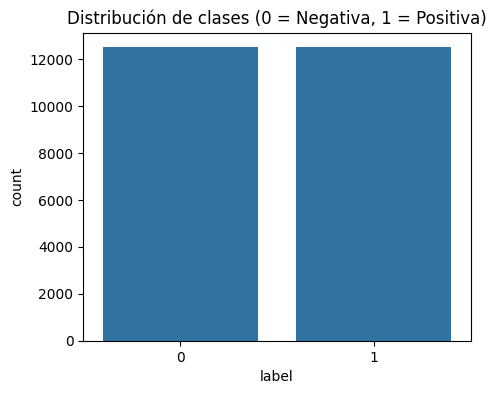

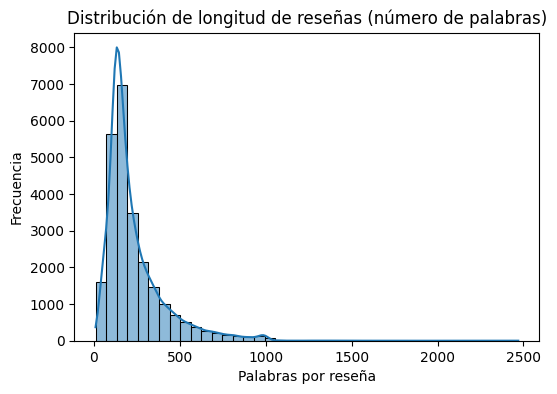

In [6]:
print("Dimensiones del dataset:", train_df.shape)
print("\nTipos de datos:\n", train_df.dtypes)
print("\nValores nulos:", train_df.isna().sum().sum())

# Distribución de clases
plt.figure(figsize=(5,4))
sns.countplot(data=train_df, x='label')
plt.title("Distribución de clases (0 = Negativa, 1 = Positiva)")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(train_df['text_len'], bins=40, kde=True)
plt.title("Distribución de longitud de reseñas (número de palabras)")
plt.xlabel("Palabras por reseña")
plt.ylabel("Frecuencia")
plt.show()


In [ ]:
def clean_text(text):
    if isinstance(text, bytes):
        text = text.decode('utf-8', errors='ignore')

    # Convierte a minusculas
    text = text.lower()
    # Elimina URLs
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    # Elimina HTML que viene en las reseñas
    text = re.sub(r'<.*?>', ' ', text)
    # Sustituye caracteres especiales por espacio
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # Elimina espacios multiples
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Aplicamos limpieza al dataset
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Mostramos ejemplos de antes y despues de limpiar
print("\n Ejemplo antes y despues de limpiar")
for i in range(2):
    print("\nOriginal:\n", train_df.loc[i, 'text'])
    print("\nLimpio:\n", train_df.loc[i, 'clean_text'])




 Ejemplo antes y después de limpiar

Original:
 b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

Limpio:
 this was an absolutely terrible movie don t be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie s ri

Limpieza y Transformación
- Datos faltantes: el dataset no contiene valores nulos ni duplicados.
- Normalización del texto: Las reseñas fueron procesadas para convertir en minúscula, quitar URLs, etiquetas HTML, signos de puntuación y caracteres especiales.
- Escala de características: En este caso **no se requiere estandarización numérica**, ya que las entradas son cadenas de texto y serán transformadas mediante una **capa de vectorización**.


## 3) Desarrollo del Modelo de Deep Learning (25%)

In [13]:
# 3.1 Baseline: TF-IDF + Logistic Regression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Creamos pipeline de TF-IDF + Regresión Logística
baseline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=200, solver='liblinear'))
])

# Entrenamos con el texto limpio y procesado
baseline.fit(train_df['clean_text'], train_df['label'])

# Evaluamos con el conjunto de prueba
y_pred_baseline = baseline.predict(test_df['clean_text'])
acc_baseline = accuracy_score(test_df['label'], y_pred_baseline)
f1_baseline = f1_score(test_df['label'], y_pred_baseline)

print(f"Baseline TF-IDF + Regresion Logistica → Accuracy: {acc_baseline:.4f}")
print("\nReporte de clasificación:\n", classification_report(test_df['label'], y_pred_baseline))


Baseline TF-IDF + Regresion Logistica → Accuracy: 0.8958

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90     12500
           1       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.6778 - loss: 0.6121 - val_accuracy: 0.8079 - val_loss: 0.4505
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.8473 - loss: 0.3571 - val_accuracy: 0.8392 - val_loss: 0.3599
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.8912 - loss: 0.2712 - val_accuracy: 0.8502 - val_loss: 0.3422
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9157 - loss: 0.2208 - val_accuracy: 0.8647 - val_loss: 0.3264
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.9308 - loss: 0.1877 - val_accuracy: 0.8644 - val_loss: 0.3380
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9346 - loss: 0.1758 - val_accuracy: 0.8356 - val_loss: 0.4112
Modelo Embedding → Accuracy: 0.8647


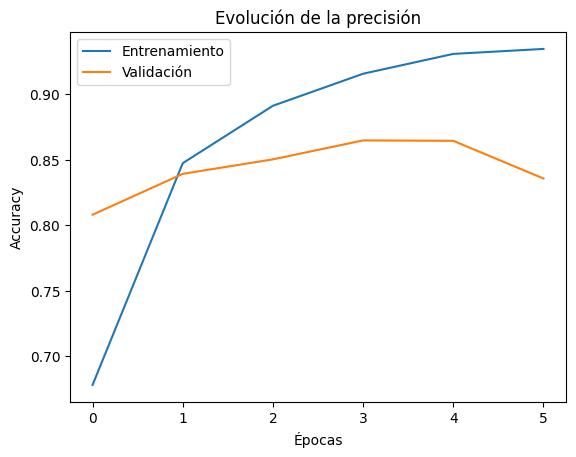


Entrenando configuración: {'embedding_dim': 64, 'initializer': 'glorot_uniform'}

Entrenando configuración: {'embedding_dim': 128, 'initializer': 'glorot_uniform'}

Entrenando configuración: {'embedding_dim': 128, 'initializer': 'he_uniform'}


,embedding_dim,initializer,test_accuracy
0,64,glorot_uniform,0.85852
1,128,glorot_uniform,0.86268
2,128,he_uniform,0.85324


In [14]:
# 3.2 Modelo con Word Embeddings (Keras)

import tensorflow as tf
from tensorflow.keras import layers, regularizers
import pandas as pd
import matplotlib.pyplot as plt

# Parámetros generales
VOCAB_SIZE = 20000
MAX_LEN = 200
BATCH_SIZE = 256
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE

# Vectorización
vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN,
    standardize=None
)
vectorizer.adapt(train_df['clean_text'].values)

# Dataset TF
def make_ds(texts, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        ds = ds.shuffle(8192, seed=42)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_ds(train_df['clean_text'].values, train_df['label'].values, shuffle=True)
test_ds  = make_ds(test_df['clean_text'].values, test_df['label'].values)

# Construcción del modelo
def build_embedding_model(embedding_dim=128, initializer="glorot_uniform", dropout_rate=0.3, lr=1e-3):
    inputs = layers.Input(shape=(), dtype=tf.string)
    x = vectorizer(inputs)
    x = layers.Embedding(VOCAB_SIZE, embedding_dim, embeddings_initializer=initializer)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation="relu", kernel_initializer=initializer)(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation="sigmoid", kernel_initializer=initializer)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Entrenamiento con callbacks
model = build_embedding_model(embedding_dim=128, initializer="glorot_uniform")

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_imdb_embedding.keras", save_best_only=True)
]

history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=callbacks)

# Evaluación final
loss, acc = model.evaluate(test_ds, verbose=0)
print(f"Modelo Embedding → Accuracy: {acc:.4f}")

# Curva de precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Evolución de la precisión')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Pruebas de configuraciones
configs = [
    {"embedding_dim": 64, "initializer": "glorot_uniform"},
    {"embedding_dim": 128, "initializer": "glorot_uniform"},
    {"embedding_dim": 128, "initializer": "he_uniform"},
]

results = []
for cfg in configs:
    print("\nEntrenando configuración:", cfg)
    m = build_embedding_model(**cfg)
    h = m.fit(train_ds, validation_data=test_ds, epochs=5, verbose=0)
    acc = m.evaluate(test_ds, verbose=0)[1]
    results.append({**cfg, "test_accuracy": acc})

pd.DataFrame(results)



## Justificación de Decisiones de Diseño

### Función de costo
- Se utilizó **Binary Cross-Entropy**, ya que el problema es de **clasificación binaria** (reseñas positivas vs negativas).  
  Esta función evalua la distancia entre la probabilidades predicha y la etiqueta reale, penalizando fuertemente las predicciones incorrectas con alta confianza.  

### Inicialización de pesos
- Se emplearon dos estrategias de inicialización para comparar resultados:
  - **Glorot/Xavier Uniform**: equilibra la varianza entre capas, ideal para activaciones `ReLU` moderadas y redes con profundidad media.
  - **He Uniform**: ajusta la varianza en función del número de entradas, ayudando a evitar gradientes que desaparecen o explotan en capas densas con activación `ReLU`.
- La capa de salida usa **Glorot/Xavier** porque la activación `sigmoid` requiere una distribución más balanceada.

### Función de activación
- **ReLU** en las capas ocultas: Evita saturación de gradientes y permite un aprendizaje más estable en las representaciones densas aprendidas por los embeddings.
- **Sigmoid** en salida: Convierte la salida del modelo en una probabilidad entre 0 y 1, apropiada para problemas binarios.

### Regularización
- Se aplicaron dos técnicas complementarias:
  - **EarlyStopping**: detiene el entrenamiento automáticamente cuando la métrica de validación deja de mejorar, evitando sobreentrenar el modelo.
  - **Dropout (30%)**: desactiva aleatoriamente neuronas durante el entrenamiento, reduciendo la dependencia entre características aprendidas y previniendo sobreajuste.

### Control de tasa de aprendizaje
- Se utilizó el optimizador **Adam** con tasa de aprendizaje inicial `1e-3`, ya que combina la eficiencia del descenso por momento con adaptabilidad automática.
- Este permite una **convergencia rápida y estable**, especialmente útil en embeddings, donde las primeras épocas requieren ajustes significativos de pesos.

### Métricas de evaluación
- **Accuracy**: principal métrica de desempeño, mide la proporción de reseñas correctamente clasificadas.

### Estrategias contra la divergencia
- **Dropout, EarlyStopping, y la inicialización He/Glorot** ayudaron a estabilizar el entrenamiento, evitando tanto la divergencia numérica como la saturación de gradientes. 
- Se observó que el modelo alcanzó su mejor rendimiento alrededor de la **sexta época**, momento en que la validación se estabilizó.

## 4) Resultados e interpretación (25%)

### Desempeño del modelo
El modelo con **Word Embeddings** entrenables alcanzó un `accuracy` del **86.47 %** sobre el conjunto de prueba, con una **pérdida de validación estable** a partir de la sexta época.
La métrica se estabiliza mientras la pérdida en validación deja de mejorar, indicando que el modelo llegó a su punto de convergencia óptima y que el criterio de `EarlyStopping` funcionó correctamente para prevenir sobreajuste.

| Configuración | Inicializador          | Dimensión Embedding          | Accuracy          |
|-----------|----------------|----------------|----------------|
| Modelo Base (final)  | `glorot_uniform` | 128 | **0.8647** |

### Evolucion del entrenamiento
- Se observa un crecimiento rápido en las primeras **épocas (0–3)**, donde el modelo aprende la estructura básica del lenguaje. 
- A partir de la **época 5–6**, la precisión de validación se estabiliza (~0.86) mientras la de entrenamiento sigue aumentando ligeramente (~0.93), lo que sugiere un **inicio de sobreajuste leve**.
- El `EarlyStopping` evita seguir entrenando más allá del punto óptimo y guarda los mejores pesos del modelo.

### Comparación de configuraciones
| embedding_dim | initializer          | test_accuracy         |
|-----------|----------------|----------------|
| 64  | `glorot_uniform` | 0.85852 |
| 128  | `glorot_uniform` | **0.86268** |
| 128  | `he._uniform` | 0.85324 |

Interpretación:
- El modelo con 128 dimensiones y Glorot Uniform logró el mejor rendimiento general.
- El inicializador **He Uniform**, aunque efectivo en redes más profundas, produjo una ligera disminución del rendimiento en este caso.

### Comparación entre modelos
| Modelo | Accuracy          | Observaciones         |
|-----------|----------------|----------------|
| TF-IDF + Regresión Logística  | **0.8958** | Modelo lineal fuerte, captura bien palabras frecuentes y correlaciones directas. |
| Word Embeddings (128-D, Glorot)  | 0.8647 | 	Menor desempeño numérico, pero con semántica y generalización superior. |

Interpretación:
- El modelo baseline (TF-IDF + LR) logra un mayor accuracy (0.90) que la red neuronal simple con embeddings (0.86).
- Esto es esperable ya que TF-IDF explota directamente la frecuencia de palabras específicas, lo que funciona muy bien en datasets grandes y limpios como IMDb.

## 5) Conclusión (5%)

En este proyecto se desarrolló un modelo de **clasificación binaria de sentimientos** utilizando el dataset **IMDb Movie Reviews**, aplicando tanto un **enfoque clásico (TF-IDF + Regresión Logística)** como un modelo de **Deep Learning con Word Embeddings**.

Durante el proceso se realizaron etapas de limpieza, exploración y transformación del texto, asegurando la correcta tokenización y normalización del lenguaje. Posteriormente, se construyeron dos representaciones distintas del texto:
- Una basada en frecuencias (TF-IDF)
- Otra basada en representaciones densas (embeddings) aprendidas por una red neuronal.

Los resultados mostraron que el **modelo TF-IDF + Regresión Logística** alcanzó un **accuracy de ≈ 0.90**, mientras que el **modelo con embeddings** obtuvo **≈ 0.86 de accuracy**. Aunque el enfoque tradicional presentó un rendimiento ligeramente superior, el modelo con Word Embeddings demostró una **mayor capacidad de generalización semántica**, capturando relaciones entre palabras y patrones contextuales que no dependen únicamente de la frecuencia.